In [1]:
# Gender Classification using ResNet18 with Augmentation and Weighted Sampling
# --------------------------------------------------
# This notebook trains a gender classification model using a real-world image dataset.
# It handles class imbalance with a WeightedRandomSampler and evaluates on a test set.

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
from PIL import Image
import numpy as np
import copy
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import argparse

In [2]:
# ---------------------- SETUP ----------------------
num_classes = 2
batch_size = 16
num_epochs = 10
learning_rate = 0.001

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# ---------------------- TRANSFORMS ----------------------
# Data augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# For validation and testing
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [4]:
# ---------------------- MODEL DEFINITION ----------------------
def get_model():
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    model.fc = nn.Sequential(
        nn.Dropout(0.4),
        nn.Linear(model.fc.in_features, num_classes)
    )
    return model.to(device)

In [5]:
def train_model(train_dir, val_dir):
    # Load datasets
    train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
    val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transform)
    class_names = train_dataset.classes

    # Weighted sampler
    targets = [label for _, label in train_dataset.samples]
    class_counts = np.bincount(targets)
    class_weights = 1. / class_counts
    sample_weights = [class_weights[label] for label in targets]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    # Loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    model = get_model()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    print("Training started...\n")
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct = 0.0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

        train_acc = correct / len(train_dataset)

        # Validation
        model.eval()
        val_correct = 0
        with torch.no_grad():
            for i, (image, label) in enumerate(val_loader):
                image, label = image.to(device), label.to(device)
                output = model(image)
                pred = torch.argmax(output, dim=1)
                if pred.item() == label.item():
                    val_correct += 1

        val_acc = val_correct / len(val_dataset)

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f"Epoch {epoch+1}/{num_epochs} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), "best_gender_model.pth")
    print(f"\n✅ Best Validation Accuracy: {best_acc:.4f}\nModel saved as 'best_gender_model.pth'\n")

    # ---------- EVALUATION ON TRAINING SET ----------
    print("\n📊 Classification Report (Training Set):\n")
    model.eval()
    train_all_preds = []
    train_all_labels = []

    with torch.no_grad():
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            train_all_preds.extend(preds.cpu().numpy())
            train_all_labels.extend(labels.cpu().numpy())

    print(classification_report(train_all_labels, train_all_preds, target_names=class_names))

    # ---------- EVALUATION ON VALIDATION SET ----------
    print("\n📊 Classification Report (Validation Set):\n")
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for image, label in val_loader:
            image = image.to(device)
            label = label.to(device)
            output = model(image)
            pred = torch.argmax(output, dim=1)

            all_preds.append(pred.item())
            all_labels.append(label.item())

    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix on Validation Set")
    plt.show()

    return class_names


In [6]:
# ---------------------- TEST FUNCTION ----------------------
def test_model(test_dir, class_names):
    test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    model = get_model()
    model.load_state_dict(torch.load("best_gender_model.pth", map_location=device))
    model.eval()

    all_preds = []
    all_labels = []
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(device)
            output = model(image)
            pred = torch.argmax(output, dim=1).cpu().item()
            all_preds.append(pred)
            all_labels.append(label.item())

    # Evaluation metrics
    report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
    cm = confusion_matrix(all_labels, all_preds)
    print("\n📊 Classification Report (Test Set):\n")
    print(report)

    # Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix on Test Set")
    plt.show()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 17.3MB/s]


Training started...

Epoch 1/10 | Train Acc: 0.8645 | Val Acc: 0.4739
Epoch 2/10 | Train Acc: 0.9071 | Val Acc: 0.8886
Epoch 3/10 | Train Acc: 0.9403 | Val Acc: 0.9384
Epoch 4/10 | Train Acc: 0.9491 | Val Acc: 0.8720
Epoch 5/10 | Train Acc: 0.9346 | Val Acc: 0.9289
Epoch 6/10 | Train Acc: 0.9517 | Val Acc: 0.9005
Epoch 7/10 | Train Acc: 0.9528 | Val Acc: 0.9194
Epoch 8/10 | Train Acc: 0.9699 | Val Acc: 0.9360
Epoch 9/10 | Train Acc: 0.9725 | Val Acc: 0.9194
Epoch 10/10 | Train Acc: 0.9600 | Val Acc: 0.9265

✅ Best Validation Accuracy: 0.9384
Model saved as 'best_gender_model.pth'


📊 Classification Report (Training Set):

              precision    recall  f1-score   support

      female       0.96      0.99      0.97       984
        male       0.99      0.95      0.97       942

    accuracy                           0.97      1926
   macro avg       0.97      0.97      0.97      1926
weighted avg       0.97      0.97      0.97      1926


📊 Classification Report (Validation Set):


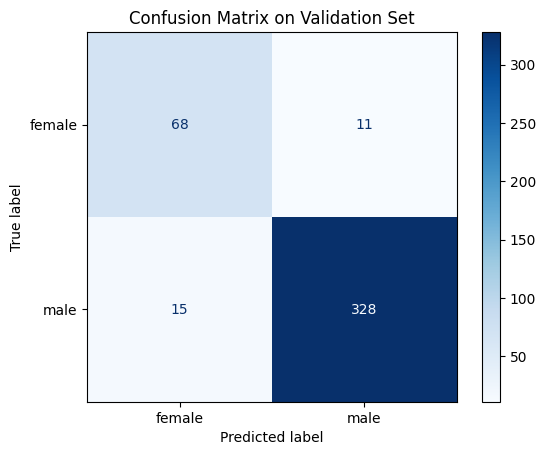

In [7]:
# ---------------------- MAIN ENTRY ----------------------
if __name__ == '__main__':
    # Sample Usage (replace with your actual paths):
    train_dir = "/kaggle/input/comsys-dataset/Comys_Hackathon5/Task_A/train"
    val_dir = "/kaggle/input/comsys-dataset/Comys_Hackathon5/Task_A/val"
    #test_dir = "/kaggle/input/comsys-dataset/Comys_Hackathon5/Task_A/test"  # Optional

    # Train the model and get class names
    class_names = train_model(train_dir, val_dir)

    # Test the saved model on test data
    #test_model(test_dir, class_names)

In [8]:
import torch

state_dict = torch.load("best_gender_model.pth", map_location=torch.device('cpu'))

# Print all layer names and shapes
for k, v in state_dict.items():
    print(f"{k}: {v.shape}")


conv1.weight: torch.Size([64, 3, 7, 7])
bn1.weight: torch.Size([64])
bn1.bias: torch.Size([64])
bn1.running_mean: torch.Size([64])
bn1.running_var: torch.Size([64])
bn1.num_batches_tracked: torch.Size([])
layer1.0.conv1.weight: torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight: torch.Size([64])
layer1.0.bn1.bias: torch.Size([64])
layer1.0.bn1.running_mean: torch.Size([64])
layer1.0.bn1.running_var: torch.Size([64])
layer1.0.bn1.num_batches_tracked: torch.Size([])
layer1.0.conv2.weight: torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight: torch.Size([64])
layer1.0.bn2.bias: torch.Size([64])
layer1.0.bn2.running_mean: torch.Size([64])
layer1.0.bn2.running_var: torch.Size([64])
layer1.0.bn2.num_batches_tracked: torch.Size([])
layer1.1.conv1.weight: torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight: torch.Size([64])
layer1.1.bn1.bias: torch.Size([64])
layer1.1.bn1.running_mean: torch.Size([64])
layer1.1.bn1.running_var: torch.Size([64])
layer1.1.bn1.num_batches_tracked: torch.Size([])
layer1.1.conv2.

In [9]:
# For example, final fully connected layer weights
fc_weights = state_dict['fc.1.weight']
fc_biases = state_dict['fc.1.bias']

print("FC Weights:", fc_weights)
print("FC Biases:", fc_biases)


FC Weights: tensor([[-0.0096,  0.0134, -0.0527,  ..., -0.0377, -0.0270, -0.0437],
        [ 0.0496,  0.0033, -0.0276,  ..., -0.0230, -0.0242, -0.0059]])
FC Biases: tensor([0.0397, 0.0141])
